# Exploring Data Spark

There are some special considerations we'll need to make when working with big or distributed data, especially when the data is larger than what we can process with pandas.

Here are several strategies for exploraing a big or distributed data set:

* Work with all of the data with spark

    This method produces the most accurate reports, but we are limited by the operations that spark provides, notably, we can't do visualization with this approach.


* Work with a sample of the data in local memory with pandas

    Another option is we could use spark to take a random sampling of the data, then work with that sample with pandas. This lets us use the tools we are already familiar with to explore the data, allows for much more visualization, and generally allows for faster iteration. We do however need to keep in mind we are working with a sample, and not the entire data, so we could be missing information.


* Aggregate the data with spark, and then work with the aggregated data locally

    That is, we could do a group by and apply an aggregate function with spark, and then transfer the resulting data to pandas to work with.

    With this approach, we won't "miss out" on anything like we have the potential to do when working with sampled data, and we have all the benefits of working locally in the pandas ecosystem. However, we are limited by the fact that we have to do aggregation; this usually results in a different shape of data, and information is lost when aggregating.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_data

In [2]:
df = wrangle_data()

In [3]:
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


df shape: (855269, 21)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 SLA_due_date         | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  el paso st,... 
 council_district     | 5                    
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_u

## Working with all the data in Spark

How many opened and closed cases are there?

In [4]:
df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18333|
|     Closed|836936|
+-----------+------+



What is the average amount of time a case is open?

In [9]:
df.groupby("case_status").agg(round(mean(df.case_lifetime)).alias("mean_case_lifetime")).show()

+-----------+------------------+
|case_status|mean_case_lifetime|
+-----------+------------------+
|       Open|              83.0|
|     Closed|               9.0|
+-----------+------------------+



## Aggregate with Spark, Visualize with Pandas

What does the case lifetime look like for each department?

Text(0.5, 0, 'Number of Cases')

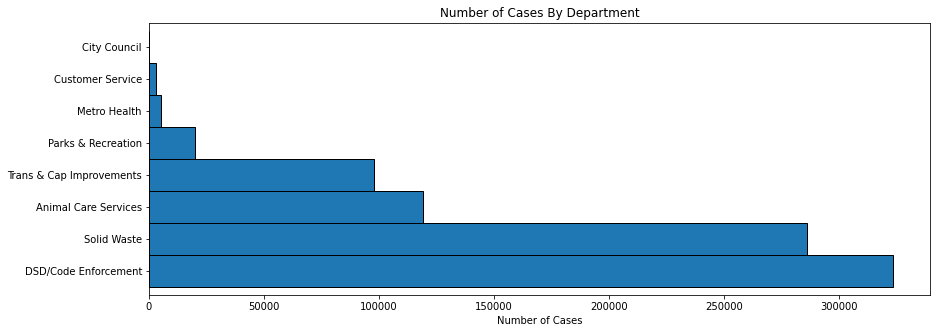

In [10]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, 'Case Lifetime By Department')

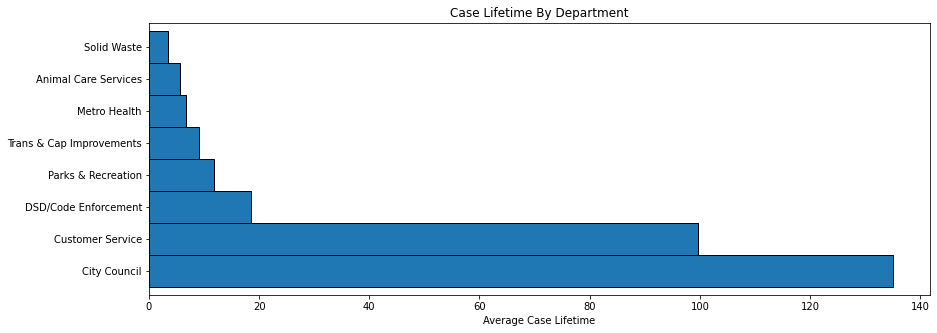

In [11]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

Average case lifetime by department for both open and closed cases:

In [12]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate=False)
)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.29 |
|Animal Care Services    |5.51  |21.3  |
|Metro Health            |6.8   |4.61  |
|Trans & Cap Improvements|7.99  |54.59 |
|Parks & Recreation      |10.68 |64.46 |
|DSD/Code Enforcement    |15.65 |91.58 |
|City Council            |24.8  |154.07|
|Customer Service        |49.52 |172.76|
+------------------------+------+------+



## Exploration of a Sample

We can choose to take a sample of our big data using the `.sample` method, convert that data to a pandas dataframe, and then work with the sample.

In [13]:
sample = df.sample(fraction = 0.01, seed = 13).toPandas()
print("Shape:", sample.shape)
sample.head()

Shape: (8608, 21)


,source_id,dept_division,case_id,case_opened_date,case_closed_date,SLA_due_date,case_late,num_days_late,case_closed,service_request_type,...,case_status,request_address,council_district,num_weeks_late,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA,source_username
0,svcCRMSS,Code Enforcement,1014127348,2018-01-01 07:05:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.706007,True,Front Or Side Yard Parking,...,Closed,"834 barrel point, san antonio, 78251",4,-2.100858,219,1.0,1,DSD/Code Enforcement,True,svcCRMSS
1,ns16326,Field Operations,1014127499,2018-01-01 13:18:00,2018-02-04 12:16:00,2018-01-06 13:18:00,True,28.957257,True,Animal Neglect,...,Closed,"717 albert st, san antonio, 78207",1,4.136751,219,34.0,34,Animal Care Services,True,Norma K. Sotoodeh
2,svcCRMSS,Code Enforcement,1014127512,2018-01-01 13:45:00,2018-01-09 09:58:00,2018-03-07 08:30:00,False,-56.938229,True,Overgrown Yard/Trash,...,Closed,rainbow dr and cloudhaven dr,10,-8.134033,219,8.0,8,DSD/Code Enforcement,True,svcCRMSS
3,139344,Signals,1014127595,2018-01-01 15:21:00,2018-01-01 15:56:00,2018-03-28 08:30:00,False,-85.690104,True,Signal Timing Modification,...,Closed,eb ih 10 and martin luther,2,-12.241443,219,0.0,0,Trans & Cap Improvements,True,Isis Mendoza
4,139344,Field Operations,1014127618,2018-01-01 15:52:00,2018-01-01 20:08:00,2020-09-26 15:52:00,False,-998.822014,True,Stray Animal,...,Closed,"407 zarzamora n, san antonio, 78207",5,-142.688859,219,0.0,0,Animal Care Services,True,Isis Mendoza


Here the `fraction` keyword argument tells spark what fraction of the data to use, and the `seed` keyword argument sets the random seed so that our random sampling is reproducible.

Now that we have the data in pandasm we can explore it with tools like seaborn's pair plot:

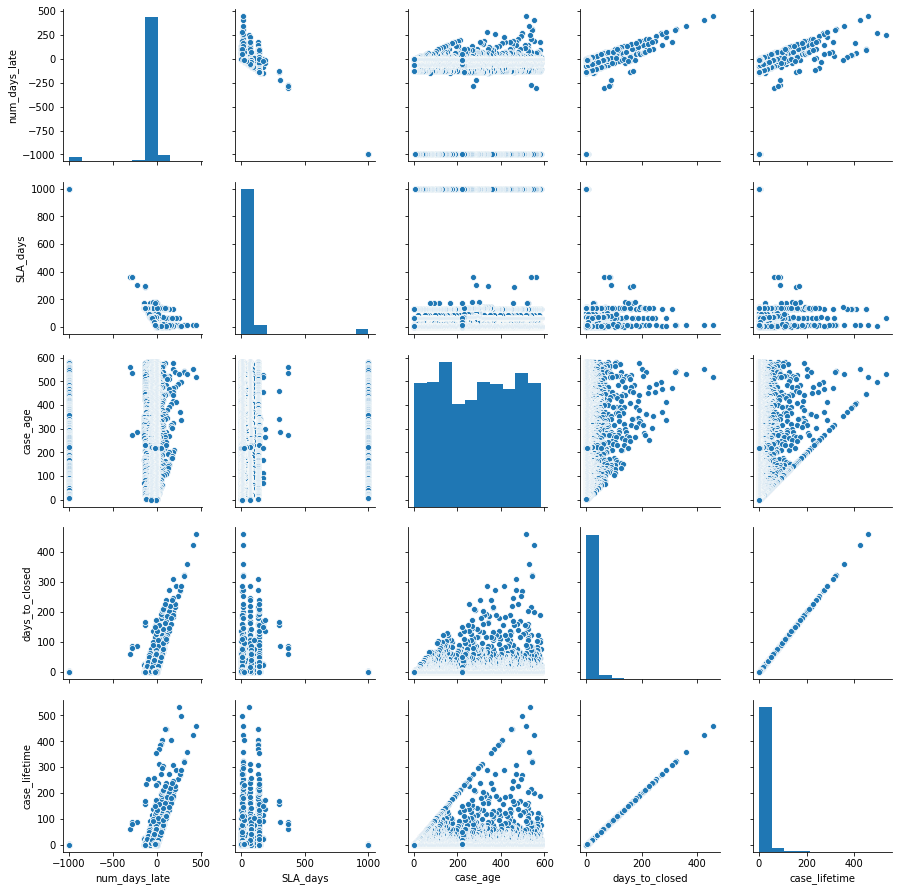

In [14]:
numeric_cols = [
    "num_days_late",
    "SLA_days",
    "case_age",
    "days_to_closed",
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

The example above would not work with a spark dataframe, and even if it did, it would take a very long time to run.

Let's explore the distribution of the `case_lifetime` feature a little more:

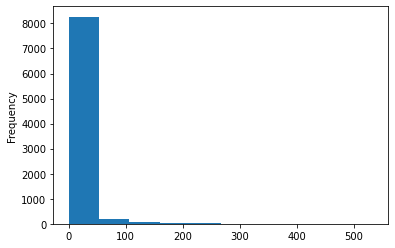

In [15]:
sample.case_lifetime.plot.hist()

It looks like the vast majority of the datapoints are closed to 0, but there are a few outliers. One way we can look at this data in a more meaningful way is to bin the data into bins of a custom width. 

For example, without setting custom bins, the results we get aren't terribly meaningful, much like the histogram above. 

In [16]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

(-0.533, 133.25]    8510
(133.25, 266.5]       73
(266.5, 399.75]       17
(399.75, 533.0]        8
Name: case_lifetime, dtype: int64

[0, 1)        2416
[1, 2)        1784
[2, 5)        1511
[5, 15)       1464
[15, 1000)    1433
Name: case_lifetime, dtype: int64


Text(0.5, 1.0, 'Overall Case Lifetime')

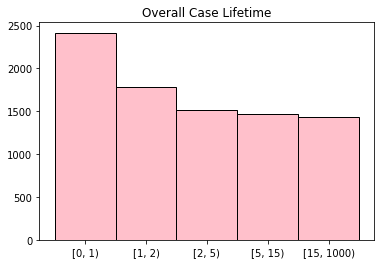

In [17]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="pink"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

Now we can see the distribution of case lifetimes a bit better

Let's see how the distribution of lifetimes for just closed cases varies:

In [18]:
closed_cases = sample.query("case_closed")
open_cases = sample.query("not case_closed")

Text(0.5, 0.98, 'Distribution of Case Lifetime')

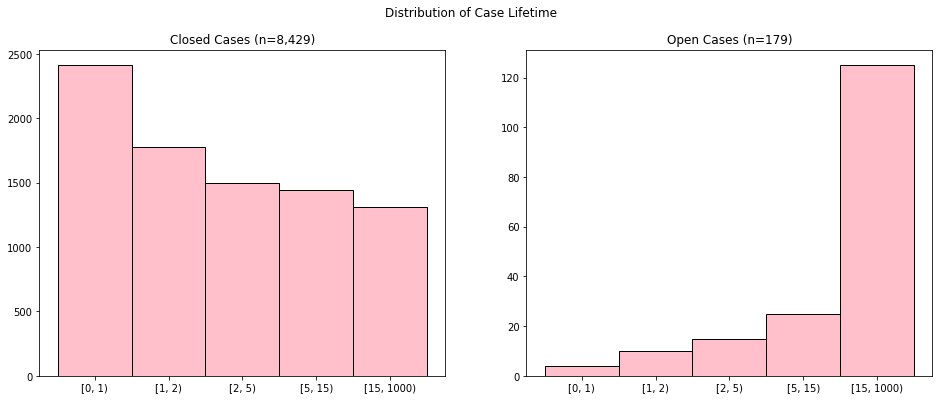

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
(
    pd.cut(closed_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)

plt.subplot(122)
(
    pd.cut(open_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.suptitle("Distribution of Case Lifetime")

## Exploring Aggregated Results

Our last strategy for exploratory analysis of big data is to use spark to aggregate our results and explore the aggregated result set. 

Here we will count the number of cases closed and opened on each date, and then explore the resulting time series dataset.

In [22]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [23]:
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [24]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'


In [25]:
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts.head(5)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1443,390
2017-01-03,1813,757
2017-01-04,1647,1247
2017-01-05,1841,1199


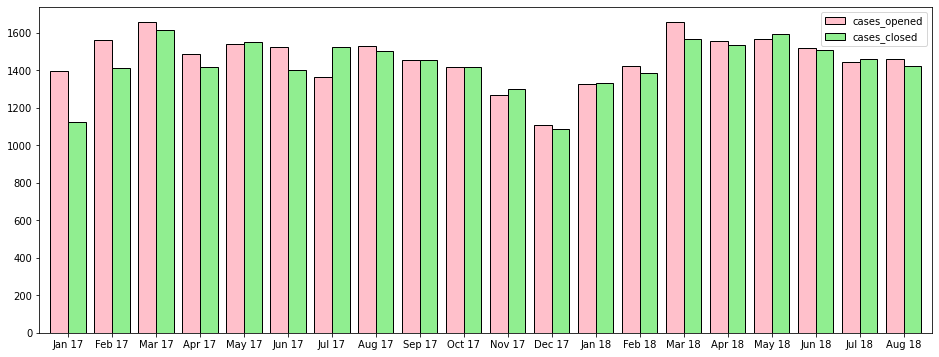

In [26]:
ts.resample("M").mean().plot.bar(
    figsize=(16, 6), width=0.8, ec="black", color=["pink", "lightgreen"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
None